In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt

import xesmf as xe
print(xe.__version__)

/albedo/home/quraus001/pyfesom/pyfesom/climatology.py:21: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


0.8.10


In [2]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/user/cwekerle/Arc08_sub/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")


In [3]:
mesh   = pf.load_mesh(meshpath)
ds_oce = fprc.load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")

file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
ds_gridded = xr.open_dataset(file)

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


In [4]:
# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)).copy()
ds_fram_bath = ds_fram_bath.rename({'lon': 'lon', 'lat': 'lat'})
ds_gridded = ds_gridded.rename({'longitude': 'lon', 'latitude': 'lat'})

# Create a new grid
grid_out = xr.Dataset({
    'lon': (['lon'], ds_gridded.lon.values),
    'lat': (['lat'], ds_gridded.lat.values),
})

# Regridder
regridder = xe.Regridder(ds_fram_bath, grid_out, method='bilinear', periodic=False)
z_interp = regridder(ds_fram_bath['z'])
# Create a mask for land points
lsmask = z_interp > 0

In [ ]:
depth_level = 0
variables = ["u", "v", "temp", "salt"]

# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)

# Create dataset for gridded data
ds_gridded = xr.Dataset(
    {
        "temp": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "salt": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "u": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "v": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
    },
    coords={
        "time": ds_oce.time.values,
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    },
)

for variable in variables:
    print(variable)
    for time_dx in tqdm(ds_oce.time.values[:]):
        # Get the data for the current time step
        raw_data     = fprc.reshape_3d_nodes(ds_oce, variable, time_idx=0)
        # Interpolate the data to the new grid
        gridded_data = pf.fesom2regular(raw_data[:,depth_level], mesh, lon_mesh, lat_mesh , how='nn')
        # Apply the mask to the gridded data
        gridded_data[lsmask] = np.nan  # Set land points to NaN
        # Store the gridded data in the dataset
        ds_gridded[variable].loc[dict(time=time_dx)] = gridded_data

# Save the gridded dataset to a NetCDF file
output_file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded.nc"
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')
ds_gridded

u


 16%|█▋        | 60/365 [03:34<18:08,  3.57s/it]

In [ ]:
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')


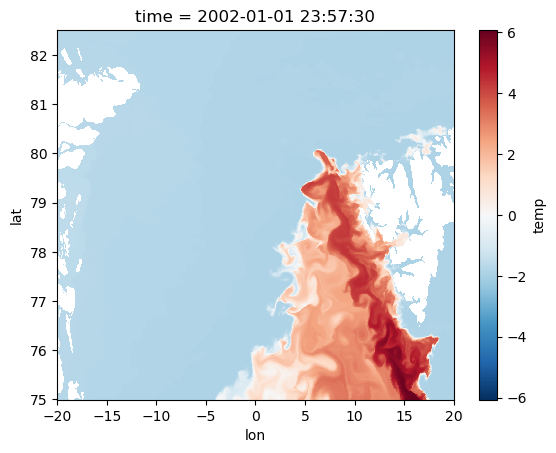

In [22]:
ds_gridded.temp.isel(time=0).plot()

-0.5458150506019592 0.5783337950706482


Text(0.5, 1.0, 'Surface field interpolated from FESOM')

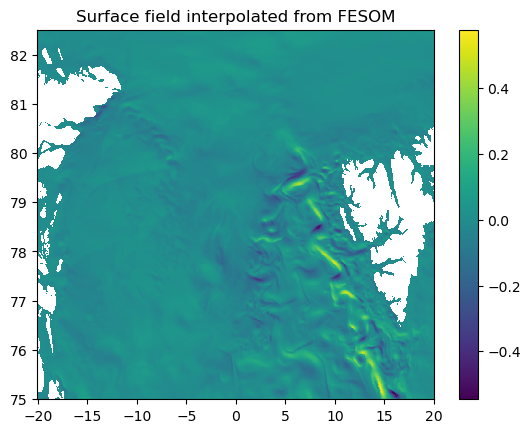

In [7]:
# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)
# Interpolate using inverse distance (more robust)
temp = fprc.reshape_3d_nodes(ds_oce, "v", time_idx=0)
interpolated = pf.fesom2regular(temp[:,0], mesh, lon_mesh, lat_mesh , how='nn')
test = np.where(interpolated == 0, np.nan, interpolated)

data = interpolated.data.copy()
# Set land points to NaN
data[lsmask] = np.nan  # Set land points to NaN
# Check and plot    
print(interpolated.min(), interpolated.max())
plt.pcolormesh(ds_gridded.lon.values, ds_gridded.lat.values, data, shading='auto')
plt.colorbar()
plt.title("Surface field interpolated from FESOM")